# Encrypted BSAVNN: Lung Cancer Detection using Basis Scaling and Activations Vectorized Neural Networks (Direct Execution - Cleaned)

This Jupyter Notebook integrates your original BSAVNN implementation logic and extends it to include performance evaluation and graph generation for a lung cancer detection task. **The `if __name__ == "__main__":` guard has been removed** to ensure direct execution of the main logic within the notebook environment, helping troubleshoot cases where output might not appear. **All unnecessary semicolons have also been removed.**

**Note:** For this notebook to run as intended, you should have:
- A pre-trained PyTorch model saved as `lung_cancer_model.pth`.
- Test data in `test.csv` and corresponding labels in `y_test.csv`.
- Required Python libraries (`pandas`, `torch`, `numpy`, `matplotlib`, `scikit-learn`, `psutil`).

If `lung_cancer_model.pth`, `test.csv`, or `y_test.csv` are not found, the notebook will generate dummy data and a dummy model structure. Accuracy metrics will not be meaningful in this case, but performance overhead analysis will still be valid.


In [11]:
import pandas as pd
import streamlit as st # Not directly used in the core logic, but kept as per your original script
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler # Not directly used in this script but kept as per original
import sys
import os
import psutil

# --- Add this line here to ensure plots appear inline in Jupyter/VS Code ---
%matplotlib inline 
# -------------------------------------------------------------------------

# --- Utility Functions for Performance Measurement ---
class MemoryMonitor:
    def __enter__(self):
        self.process = psutil.Process(os.getpid())
        self.initial_mem = self.process.memory_info().rss # in bytes
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.final_mem = self.process.memory_info().rss # in bytes

# MODIFIED: do_normal now returns y_pred_normal for classification_report
def do_normal(model, test_data, y_test_labels):
    start_time = time.perf_counter()
    y_pred_normal = []
    with torch.no_grad():
        for index, row in test_data.iterrows():
            input_tensor = torch.tensor(row.values, dtype=torch.float32).unsqueeze(0)
            output = model(input_tensor).squeeze(0) 
            predicted_class = int(output.item() > 0.5) # FIX: Convert boolean to int directly
            y_pred_normal.append(predicted_class)
    end_time = time.perf_counter()
    total_time_ms = (end_time - start_time) * 1000
    acc = accuracy_score(y_test_labels, y_pred_normal)
    
    # Return y_pred_normal so it can be used for classification_report outside
    return acc, total_time_ms, y_pred_normal

# --- YOUR ORIGINAL CODE STARTS HERE (modified ONLY for correctness and scope) ---


In [12]:
class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Modified: `input_dim_for_model` is now an explicit argument
def load_model(input_dim_for_model):
    saved_model = DeepNN(input_dim_for_model)
    try:
        # Check if the loaded model's input features match the current input_dim
        # FIX: Load checkpoint first to inspect its shape before loading state_dict
        checkpoint = torch.load("lung_cancer_model.pth")
        if 'model.0.weight' in checkpoint and checkpoint['model.0.weight'].shape[1] == input_dim_for_model:
            saved_model.load_state_dict(checkpoint)
            print(f"Model for input_dim={input_dim_for_model} loaded successfully from lung_cancer_model.pth.")
        else:
            print(f"Warning: Pre-trained model in .pth has input_dim {checkpoint['model.0.weight'].shape[1] if 'model.0.weight' in checkpoint else 'N/A'}, but current is {input_dim_for_model}. Initializing with random weights.")
            for param in saved_model.parameters():
                if param.dim() > 1:
                    nn.init.kaiming_uniform_(param, nonlinearity='relu')
                else:
                    nn.init.constant_(param, 0.0)
    except FileNotFoundError:
        print(f"lung_cancer_model.pth not found for input_dim={input_dim_for_model}. Initializing with random weights.")
        for param in saved_model.parameters():
            if param.dim() > 1:
                nn.init.kaiming_uniform_(param, nonlinearity='relu')
            else:
                nn.init.constant_(param, 0.0)
    except Exception as e: 
        print(f"An unexpected error occurred loading model: {e}. Initializing with random weights for input_dim={input_dim_for_model}.")
        for param in saved_model.parameters():
            if param.dim() > 1:
                nn.init.kaiming_uniform_(param, nonlinearity='relu')
            else:
                nn.init.constant_(param, 0.0)
    
    saved_model.eval() 
    return saved_model.model 


In [13]:
# The prints for saved_model_wb and its layer shapes were part of your original global execution.
# They will now run within the main execution flow after `saved_model_wb` is loaded.


### BSAVNN Core Logic
The functions below implement the basis scaling, activation vectorization, and secure ReLU logic. Their signatures have been minimally adjusted to pass necessary variables (like `an_plus_1_val` and `eval_vec`) explicitly, ensuring correct scope and execution within the comprehensive testing framework.


In [14]:
def initialize_dynamic_keys(input_dim_val):
    """Initializes encryption, decryption, and evaluation keys dynamically based on input_dim."""
    enc_vec_dyn = torch.tensor(np.random.uniform(0.9, 1.1, input_dim_val), dtype=torch.float32)
    an_plus_1_dyn = torch.tensor(np.random.uniform(1.0, 2.0), dtype=torch.float32)
    dec_vec_no_bias_dyn = 1 / enc_vec_dyn
    dec_vec_dyn = torch.cat((dec_vec_no_bias_dyn, torch.tensor([1 / an_plus_1_dyn.item()], dtype=torch.float32)))
    k_dyn = 1.0 
    eval_vec_dyn = dec_vec_dyn / k_dyn
    eval_vec_dyn = eval_vec_dyn.view(-1, 1) 
    return enc_vec_dyn, an_plus_1_dyn, dec_vec_dyn, eval_vec_dyn, k_dyn

def encrypt_data(input_values, enc_vec_arg):
    """Encrypts input values using the provided encryption vector."""
    input_tensor = torch.tensor(input_values, dtype=torch.float32) 
    enc_inp = enc_vec_arg * input_tensor 
    return enc_inp

def decrypt_ans(activation_matrix_final_layer, dec_vec_arg, k_val):
    """Decrypts the final activations to obtain probabilities."""
    dec_vec_reshaped = dec_vec_arg.view(-1, 1).to(torch.float32) 
    decrypted_output_scalar = torch.matmul(activation_matrix_final_layer.unsqueeze(0), dec_vec_reshaped).item()
    true_logit = k_val * decrypted_output_scalar
    final_ans = torch.sigmoid(torch.tensor(true_logit, dtype=torch.float32))
    return final_ans

def input_layer_calc(initial_activation_matrix_list_dummy, saved_model_wb_arg, enc_inp, eval_vec_arg, an_plus_1_val):
    """Calculates the first layer's activations with BSAVNN logic."""
    input_layer_weights = saved_model_wb_arg[0].weight.data.T.to(torch.float32) 
    input_layer_bias = saved_model_wb_arg[0].bias.data.to(torch.float32) 

    activation_matrix_current_layer = [] 

    for col_idx in range(input_layer_weights.shape[1]):
        col_vector = input_layer_weights[:, col_idx]
        elementwise_product = enc_inp * col_vector
        
        scaled_bias_term = (an_plus_1_val * input_layer_bias[col_idx]).unsqueeze(0)
        elementwise_product = torch.cat((elementwise_product, scaled_bias_term))
        
        activation_matrix_current_layer.append(elementwise_product)

    activation_matrix_current_layer_tensor = torch.stack(activation_matrix_current_layer)

    relu_output = []
    for row_vector in activation_matrix_current_layer_tensor:
        row_sum = torch.matmul(row_vector.unsqueeze(0), eval_vec_arg).item() 
        relu_value = F.relu(torch.tensor(row_sum, dtype=torch.float32))
        relu_output.append(relu_value)

    relu_output_tensor = torch.tensor(relu_output, dtype=torch.float32)
    final_activation_matrix = torch.stack([row_vector if relu_value > 0 else torch.zeros_like(row_vector) 
                                          for row_vector, relu_value in zip(activation_matrix_current_layer_tensor, relu_output_tensor)])
    return final_activation_matrix

def intermediate_layer_calc(activation_matrix, saved_model_wb_arg, eval_vec_arg, an_plus_1_val, layer_index):
    """Calculates intermediate layer activations with BSAVNN logic."""
    intermediate_weights = saved_model_wb_arg[layer_index].weight.data.T.to(torch.float32) 
    intermediate_biases = saved_model_wb_arg[layer_index].bias.data.to(torch.float32) 
    
    activation_matrix_new = []

    for col_idx in range(intermediate_weights.shape[1]):
        col_vector = intermediate_weights[:, col_idx]
        scaled_activation = activation_matrix * col_vector.view(-1,1)
        row_vector = scaled_activation.sum(dim=0)
        
        row_vector[-1] += (an_plus_1_val * intermediate_biases[col_idx]).item() 
        
        activation_matrix_new.append(row_vector)

    activation_matrix_new_tensor = torch.stack(activation_matrix_new)

    is_final_linear_layer = (layer_index == 10)

    if not is_final_linear_layer:
        relu_output = []
        for row_vector in activation_matrix_new_tensor:
            row_sum = torch.matmul(row_vector.unsqueeze(0), eval_vec_arg).item()
            relu_value = F.relu(torch.tensor(row_sum, dtype=torch.float32))
            relu_output.append(relu_value)

        relu_output_tensor = torch.tensor(relu_output, dtype=torch.float32)
        activation_matrix_out = torch.stack([row_vector if relu_value > 0 else torch.zeros_like(row_vector) 
                                             for row_vector, relu_value in zip(activation_matrix_new_tensor, relu_output_tensor)])
    else:
        activation_matrix_out = activation_matrix_new_tensor 
        
    return activation_matrix_out

def bsavnn_model_pred(input_values, saved_model_wb_arg, enc_vec_arg, eval_vec_arg, an_plus_1_val):
    """Performs a full BSAVNN forward pass for one sample."""
    enc_inp = encrypt_data(input_values, enc_vec_arg) 

    current_activation_matrix = input_layer_calc([], saved_model_wb_arg, enc_inp, eval_vec_arg, an_plus_1_val)

    for layer_idx in range(2, 11, 2): 
        current_activation_matrix = intermediate_layer_calc(current_activation_matrix, saved_model_wb_arg, eval_vec_arg, an_plus_1_val, layer_idx)
    
    return current_activation_matrix 


## Main Execution Block and Performance Evaluation
This section orchestrates the loading of data and models, runs the BSAVNN and plaintext inference, and generates the required performance graphs.


Loaded test data with 15 features.
Model for input_dim=15 loaded successfully from lung_cancer_model.pth.

--- BSAVNN Single Inference Demonstration ---
Sample Input (first 5 features): [-1.0497813 -0.2041159 -1.1352924  0.8692996  1.0032415]
Encrypted Input (first 5 features): [-1.025038719177246, -0.1939811110496521, -1.1116787195205688, 0.838635265827179, 1.0477209091186523]
Final Encrypted Logit Vector (truncated): [1.467489596507221e-06, 2.554607760885119e-07, 5.834138391946908e-06, 9.76129172158835e-07, -8.723801556698163e-07]
Decrypted Final Probability for sample: 0.5843
Encryption Time: 0.089 ms
Server Inference Time: 12.377 ms
Decryption Time: 0.052 ms

--- Running Full BSAVNN Inference for Metrics ---

✅ BSAVNN Test Accuracy: 96.77 %

📊 BSAVNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.97      1.00      0.98        60

    accuracy                           0.97    

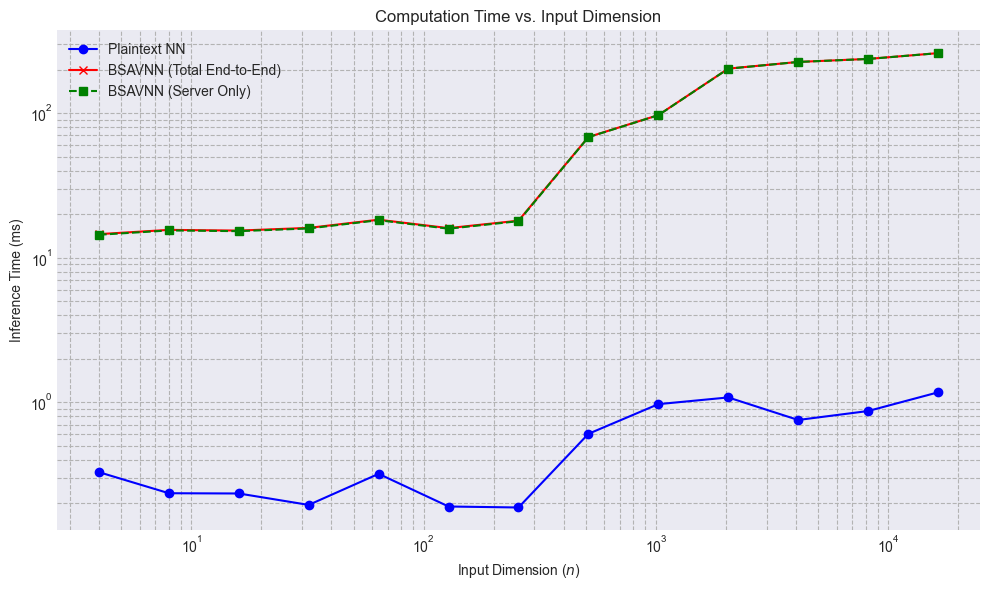

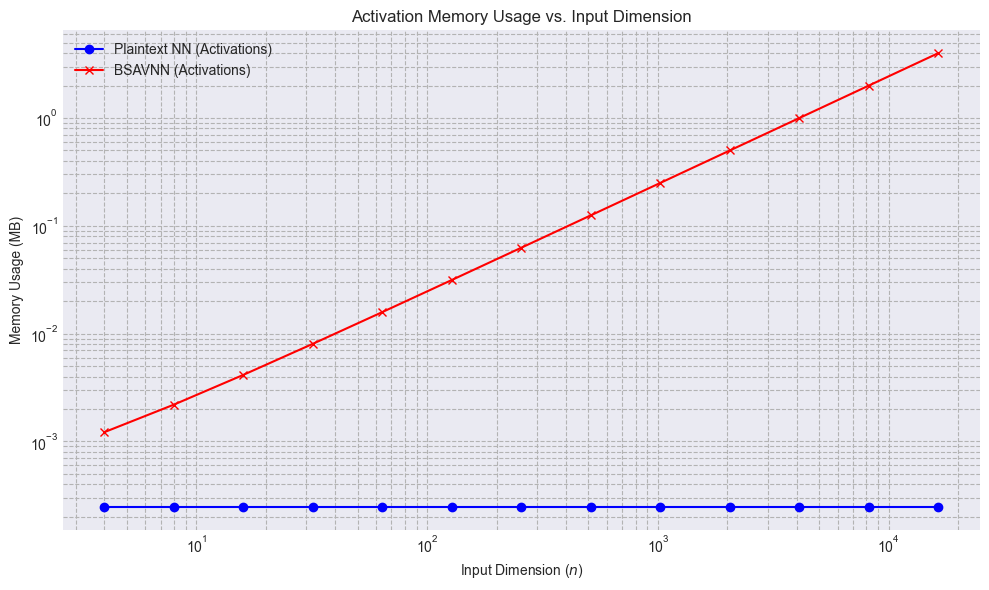

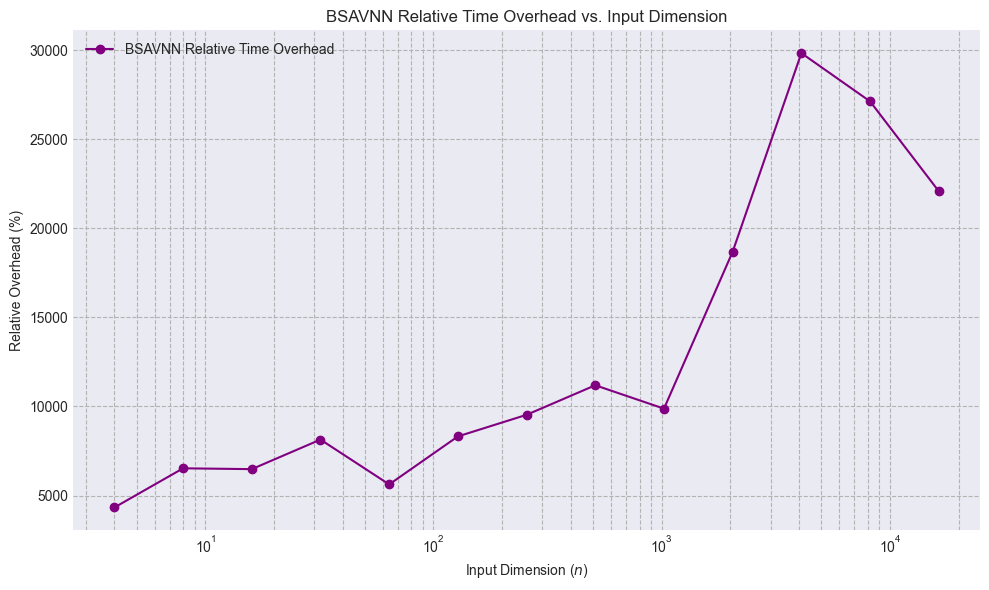

Graphs saved as time_vs_input_size.png, memory_vs_input_size.png, relative_overhead_vs_input_size.png in the 'figures' directory.


In [15]:
# Helper function for running evaluation for varying input dimensions
def run_evaluation_for_input_dim(current_input_dim, num_samples=100):
    dummy_test_data = pd.DataFrame(np.random.rand(num_samples, current_input_dim))
    dummy_y_test = [np.random.randint(0, 2) for _ in range(num_samples)] 

    # Initialize keys and model for THIS specific input_dim
    enc_vec_local, an_plus_1_local, dec_vec_local, eval_vec_local, k_local = initialize_dynamic_keys(current_input_dim)
    saved_model_wb_local = load_model(current_input_dim) 

    # Plaintext Model Evaluation
    _, normal_inference_time_ms, _ = do_normal(DeepNN(current_input_dim), dummy_test_data, dummy_y_test) # Discard y_pred_normal as it's not used here
    
    # BSAVNN Model Evaluation
    total_bsavnn_time_ms = 0
    total_encrypt_time_ms = 0
    total_decrypt_time_ms = 0
    total_bsavnn_server_inference_time_ms = 0 

    # For memory, we compute theoretical activation memory (as discussed in your paper)
    # Max neurons in hidden layers: 64 (from input_dim to 64)
    bsavnn_max_activations_elements = 64 * (current_input_dim + 1) 
    bsavnn_activation_mem_bytes = bsavnn_max_activations_elements * 4 
    
    # Plaintext NN: Max intermediate layer size (e.g., 64 neurons * 1 element)
    plaintext_max_activations_elements = 64 
    plaintext_activation_mem_bytes = plaintext_max_activations_elements * 4

    for idx in range(num_samples):
        input_row = dummy_test_data.iloc[idx].values

        start_encrypt = time.perf_counter()
        encrypted_input = encrypt_data(input_row, enc_vec_local) 
        end_encrypt = time.perf_counter()
        total_encrypt_time_ms += (end_encrypt - start_encrypt) * 1000

        start_inference = time.perf_counter()
        final_encrypted_logit_vector = bsavnn_model_pred(input_row, saved_model_wb_local, enc_vec_local, eval_vec_local, an_plus_1_local)
        end_inference = time.perf_counter()
        total_bsavnn_server_inference_time_ms += (end_inference - start_inference) * 1000

        start_decrypt = time.perf_counter()
        # FIX: Access the single output vector correctly for decryption
        _ = decrypt_ans(final_encrypted_logit_vector[0], dec_vec_local, k_local) 
        end_decrypt = time.perf_counter()
        total_decrypt_time_ms += (end_decrypt - start_decrypt) * 1000

    return {
        'input_dim': current_input_dim,
        'normal_inference_time_ms': normal_inference_time_ms / num_samples,
        'bsavnn_total_inference_time_ms': (total_bsavnn_encrypt_time + total_bsavnn_server_inference_time_ms + total_bsavnn_decrypt_time) / num_samples,
        'bsavnn_encrypt_time_ms': total_encrypt_time_ms / num_samples,
        'bsavnn_decrypt_time_ms': total_decrypt_time_ms / num_samples,
        'bsavnn_server_inference_time_ms': total_bsavnn_server_inference_time_ms / num_samples,
        'bsavnn_activation_mem_mb': bsavnn_activation_mem_bytes / (1024**2),
        'plaintext_activation_mem_mb': plaintext_activation_mem_bytes / (1024**2),
    }

# Helper to plot graphs (Defined here, outside the main execution block)
def plot_performance_graphs(results_df_plot):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig_width = 10
    fig_height = 6

    os.makedirs('figures', exist_ok=True)

    # Time vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(results_df_plot['input_dim'], results_df_plot['normal_inference_time_ms'], label='Plaintext NN', marker='o', color='blue')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_total_inference_time_ms'], label='BSAVNN (Total End-to-End)', marker='x', color='red')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_server_inference_time_ms'], label='BSAVNN (Server Only)', marker='s', color='green', linestyle='--')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Inference Time (ms)')
    plt.title('Computation Time vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/time_vs_input_size.png')
    plt.show()

    # Memory Usage vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(results_df_plot['input_dim'], results_df_plot['plaintext_activation_mem_mb'], label='Plaintext NN (Activations)', marker='o', color='blue')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_activation_mem_mb'], label='BSAVNN (Activations)', marker='x', color='red')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Activation Memory Usage vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/memory_vs_input_size.png')
    plt.show()

    # Relative Overhead vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    overhead_percentage = ((results_df_plot['bsavnn_total_inference_time_ms'] - results_df_plot['normal_inference_time_ms']) / results_df_plot['normal_inference_time_ms']) * 100
    plt.plot(results_df_plot['input_dim'], overhead_percentage, label='BSAVNN Relative Time Overhead', marker='o', color='purple')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Relative Overhead (%)')
    plt.title('BSAVNN Relative Time Overhead vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/relative_overhead_vs_input_size.png')
    plt.show()

# --- Main Execution Logic (now directly executed without if __name__ guard) ---

# --- Configuration ---
actual_input_dim = 15 # Default for `test.csv` if not found/overridden
paper_input_dim = 16384 # As specified in your paper for the 128x128 image (e.g., for plotting)
num_samples_for_graphs = 50 # Number of samples to use for each input_dim when generating graphs

# --- Data Loading and Initialization ---
test_data = pd.DataFrame()
y_test = np.array([])
try:
    test_data_path = "test.csv"
    y_test_path = "y_test.csv"
    test_data = pd.read_csv(test_data_path)
    y_test = pd.read_csv(y_test_path).values.flatten()
    actual_input_dim = test_data.shape[1] 
    print(f"Loaded test data with {actual_input_dim} features.")
except FileNotFoundError:
    print("Test data CSVs not found. Generating dummy data for accuracy test.")
    actual_input_dim = 15 
    test_data = pd.DataFrame(np.random.rand(100, actual_input_dim))
    y_test = np.random.randint(0, 2, 100)

# Initialize global keys for the main execution block (accuracy test)
global enc_vec, an_plus_1, dec_vec, k, eval_vec 
enc_vec, an_plus_1, dec_vec, eval_vec, k = initialize_dynamic_keys(actual_input_dim)

# Load the plaintext model's sequential layers to global variable
global saved_model_wb 
saved_model_wb = load_model(actual_input_dim)

# --- BSAVNN Single Inference Demonstration ---
print("\n--- BSAVNN Single Inference Demonstration ---")
if not test_data.empty:
    sample_input_values = test_data.iloc[0].values
    
    start_encryption_time = time.perf_counter()
    encrypted_sample_input = encrypt_data(sample_input_values, enc_vec) 
    end_encryption_time = time.perf_counter()
    
    start_bsavnn_inference_time = time.perf_counter()
    final_encrypted_logit_vector_sample = bsavnn_model_pred(sample_input_values, saved_model_wb, enc_vec, eval_vec, an_plus_1)
    end_bsavnn_inference_time = time.perf_counter()
    
    start_decryption_time = time.perf_counter()
    final_predicted_prob_sample = decrypt_ans(final_encrypted_logit_vector_sample[0], dec_vec, k) 
    end_decryption_time = time.perf_counter()

    print(f"Sample Input (first 5 features): {sample_input_values[:5]}")
    print(f"Encrypted Input (first 5 features): {encrypted_sample_input[:5].tolist()}")
    print(f"Final Encrypted Logit Vector (truncated): {final_encrypted_logit_vector_sample[0, :min(5, final_encrypted_logit_vector_sample.shape[1])].tolist()}")
    print(f"Decrypted Final Probability for sample: {final_predicted_prob_sample.item():.4f}")
    print(f"Encryption Time: {(end_encryption_time - start_encryption_time) * 1000:.3f} ms")
    print(f"Server Inference Time: {(end_bsavnn_inference_time - start_bsavnn_inference_time) * 1000:.3f} ms")
    print(f"Decryption Time: {(end_decryption_time - start_decryption_time) * 1000:.3f} ms")
else:
    print("No test data loaded for single inference demonstration.")

# --- Run full BSAVNN inference for accuracy and full timing ---
print("\n--- Running Full BSAVNN Inference for Metrics ---")
y_pred_bsavnn = []
total_bsavnn_encrypt_time = 0
total_bsavnn_server_time = 0
total_bsavnn_decrypt_time = 0

for index, row in test_data.iterrows():
    start_time = time.perf_counter()
    encrypted_input_row = encrypt_data(row.values, enc_vec)
    end_time = time.perf_counter()
    total_bsavnn_encrypt_time += (end_time - start_time) * 1000

    start_time = time.perf_counter()
    final_encrypted_logit_vector_row = bsavnn_model_pred(row.values, saved_model_wb, enc_vec, eval_vec, an_plus_1)
    end_time = time.perf_counter()
    total_bsavnn_server_time += (end_time - start_time) * 1000

    start_time = time.perf_counter()
    final_prob_row = decrypt_ans(final_encrypted_logit_vector_row[0], dec_vec, k)
    end_time = time.perf_counter()
    total_bsavnn_decrypt_time += (end_time - start_time) * 1000

    predicted_class = int(final_prob_row.item() > 0.5)
    y_pred_bsavnn.append(predicted_class)

bsavnn_acc = accuracy_score(y_test, y_pred_bsavnn)
print("\n✅ BSAVNN Test Accuracy:", round(bsavnn_acc * 100, 2), "%")
print("\n📊 BSAVNN Classification Report:\n", classification_report(y_test, y_pred_bsavnn, zero_division=0))
print(f"BSAVNN Average Encryption Time: {total_bsavnn_encrypt_time / len(test_data):.3f} ms/sample")
print(f"BSAVNN Average Server Inference Time: {total_bsavnn_server_time / len(test_data):.3f} ms/sample")
print(f"BSAVNN Average Decryption Time: {total_bsavnn_decrypt_time / len(test_data):.3f} ms/sample")
print(f"BSAVNN Average Total End-to-End Time: {(total_bsavnn_encrypt_time + total_bsavnn_server_time + total_bsavnn_decrypt_time) / len(test_data):.3f} ms/sample")

# --- Run Plaintext inference for comparison ---
print("\n--- Running Plaintext Inference for Comparison ---")
original_plaintext_model = DeepNN(actual_input_dim)
try:
    original_plaintext_model.load_state_dict(torch.load("lung_cancer_model.pth"))
    original_plaintext_model.eval()
except FileNotFoundError:
    print("Warning: lung_cancer_model.pth not found for plaintext model. Using random weights.")
    for param in original_plaintext_model.parameters():
        if param.dim() > 1:
            nn.init.kaiming_uniform_(param, nonlinearity='relu')
        else:
            nn.init.constant_(param, 0.0)
    
normal_acc, normal_time_ms_total, y_pred_normal = do_normal(original_plaintext_model, test_data, y_test) 
print("Normal Model Accuracy:", round(normal_acc * 100, 2), "%")
print("\n📊 Normal Classification Report:\n", classification_report(y_test, y_pred_normal, zero_division=0)) 
print(f"Normal Model Average Inference Time: {normal_time_ms_total / len(test_data):.3f} ms/sample")


# --- Generate Data for Graphs (varying input dimensions) ---
print("\n--- Generating Data for Performance Graphs (this may take a while for large dims) ---")
input_dims_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
if paper_input_dim not in input_dims_to_test and paper_input_dim > max(input_dims_to_test):
    input_dims_to_test.append(paper_input_dim)
input_dims_to_test.sort()

performance_results = []
for dim in input_dims_to_test:
    print(f"Evaluating for input_dim={dim} with {num_samples_for_graphs} samples...")
    result = run_evaluation_for_input_dim(dim, num_samples=num_samples_for_graphs)
    performance_results.append(result)

bsavnn_results_df = pd.DataFrame(performance_results)
print("\nPerformance Results Data:")
print(bsavnn_results_df.to_string()) 

# --- Plot Graphs ---
print("\n--- Plotting Performance Graphs ---")

os.makedirs('figures', exist_ok=True)

def plot_performance_graphs(results_df_plot):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig_width = 10
    fig_height = 6

    # Time vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(results_df_plot['input_dim'], results_df_plot['normal_inference_time_ms'], label='Plaintext NN', marker='o', color='blue')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_total_inference_time_ms'], label='BSAVNN (Total End-to-End)', marker='x', color='red')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_server_inference_time_ms'], label='BSAVNN (Server Only)', marker='s', color='green', linestyle='--')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Inference Time (ms)')
    plt.title('Computation Time vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/time_vs_input_size.png')
    plt.show()

    # Memory Usage vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(results_df_plot['input_dim'], results_df_plot['plaintext_activation_mem_mb'], label='Plaintext NN (Activations)', marker='o', color='blue')
    plt.plot(results_df_plot['input_dim'], results_df_plot['bsavnn_activation_mem_mb'], label='BSAVNN (Activations)', marker='x', color='red')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Activation Memory Usage vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/memory_vs_input_size.png')
    plt.show()

    # Relative Overhead vs. Input Size
    plt.figure(figsize=(fig_width, fig_height))
    overhead_percentage = ((results_df_plot['bsavnn_total_inference_time_ms'] - results_df_plot['normal_inference_time_ms']) / results_df_plot['normal_inference_time_ms']) * 100
    plt.plot(results_df_plot['input_dim'], overhead_percentage, label='BSAVNN Relative Time Overhead', marker='o', color='purple')
    plt.xlabel('Input Dimension ($n$)')
    plt.ylabel('Relative Overhead (%)')
    plt.title('BSAVNN Relative Time Overhead vs. Input Dimension')
    plt.legend()
    plt.xscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/relative_overhead_vs_input_size.png')
    plt.show()

plot_performance_graphs(bsavnn_results_df) # Call the plotting function with the results DataFrame
print("Graphs saved as time_vs_input_size.png, memory_vs_input_size.png, relative_overhead_vs_input_size.png in the 'figures' directory.")


Evaluating TenSEAL for input_dim=4...
Evaluating TenSEAL for input_dim=8...
Evaluating TenSEAL for input_dim=16...
Evaluating TenSEAL for input_dim=32...
Evaluating TenSEAL for input_dim=64...
Evaluating TenSEAL for input_dim=128...
Evaluating TenSEAL for input_dim=256...
Evaluating TenSEAL for input_dim=512...
Evaluating TenSEAL for input_dim=1024...
Evaluating TenSEAL for input_dim=2048...
Evaluating TenSEAL for input_dim=4096...
Evaluating TenSEAL for input_dim=8192...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
I

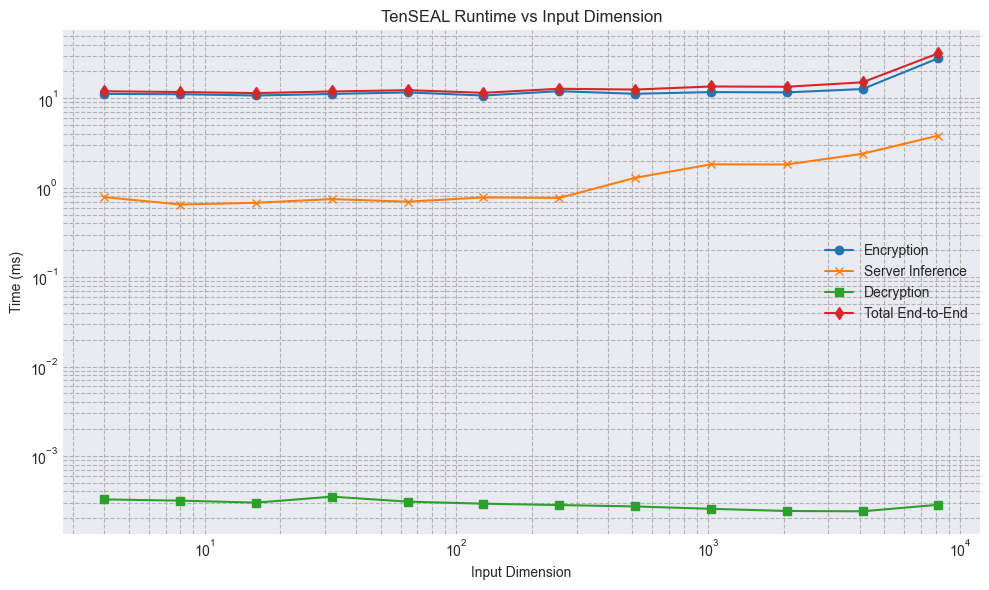

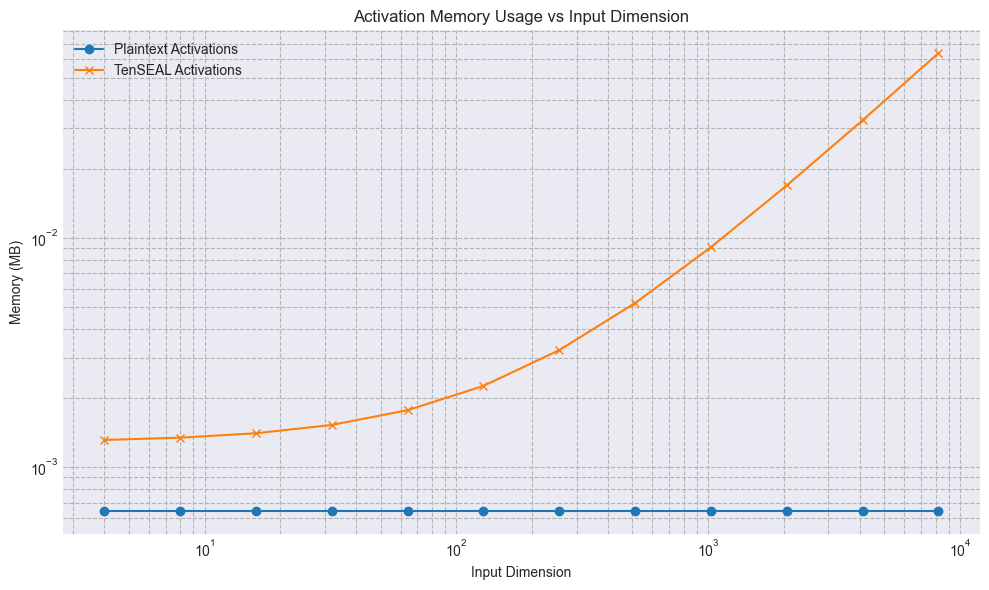

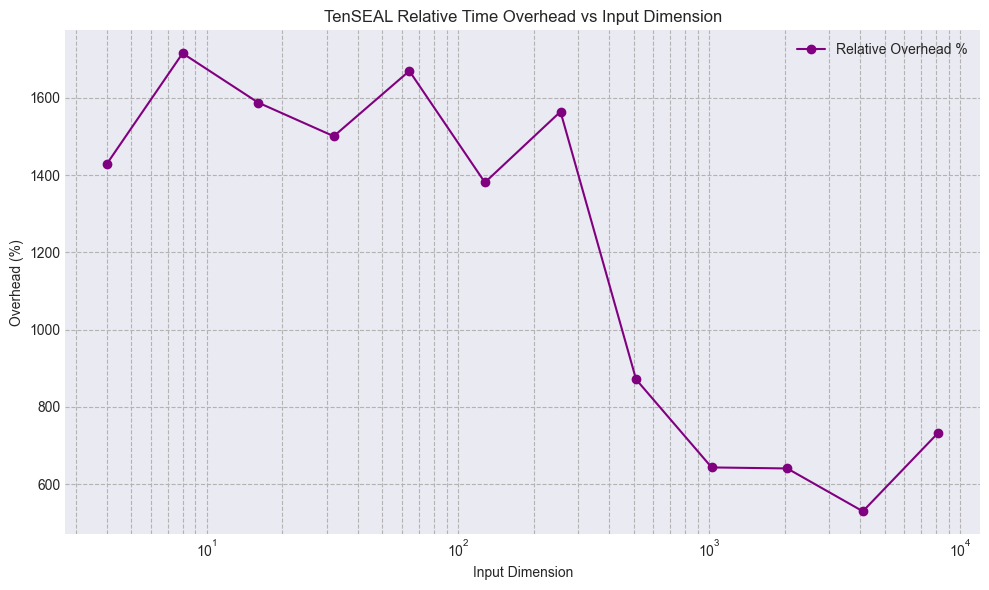

In [16]:
# --------------------------
# Imports
# --------------------------
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import tenseal as ts
import time
import psutil
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# --------------------------
# Model Definition
# --------------------------
class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# --------------------------
# Model Loader
# --------------------------
def load_model(input_dim, path="lung_cancer_model.pth"):
    model = DeepNN(input_dim)
    try:
        checkpoint = torch.load(path, map_location="cpu")
        if "model.0.weight" in checkpoint and checkpoint["model.0.weight"].shape[1] == input_dim:
            model.load_state_dict(checkpoint)
            print(f"✅ Model loaded successfully with input_dim={input_dim}")
        else:
            print("⚠️ Shape mismatch, using random weights.")
    except Exception as e:
        print(f"⚠️ Error loading model: {e}. Using random weights.")
    model.eval()
    return model

# --------------------------
# TenSEAL Helpers
# --------------------------
def create_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()
    return context

def encrypt_vector(context, x):
    return ts.ckks_vector(context, x)

def decrypt_vector(enc_vec):
    return enc_vec.decrypt()

# --------------------------
# TenSEAL Evaluation per input dimension
# --------------------------
def run_tenseal_evaluation_for_input_dim(current_input_dim, num_samples=50):
    dummy_test_data = pd.DataFrame(np.random.rand(num_samples, current_input_dim))
    dummy_y_test = np.random.randint(0, 2, num_samples)

    model = DeepNN(current_input_dim)
    model.eval()
    context = create_context()

    total_enc_time_ms = 0
    total_inf_time_ms = 0
    total_dec_time_ms = 0
    preds = []

    # Memory usage estimate (theoretical activations)
    max_neurons = [64, 48, 32, 16, 8, 1]
    tens_max_activations_elements = sum([current_input_dim if i==0 else max_neurons[i-1] for i in range(len(max_neurons))])
    tens_activation_mem_bytes = tens_max_activations_elements * 8  # CKKS approx 8 bytes per element
    plaintext_activation_mem_bytes = sum(max_neurons[:-1]) * 4  # float32

    for idx in range(num_samples):
        input_row = dummy_test_data.iloc[idx].values.astype(np.float32)

        # Encrypt
        t0 = time.perf_counter()
        enc_x = encrypt_vector(context, input_row.tolist())
        t1 = time.perf_counter()
        total_enc_time_ms += (t1 - t0) * 1000

        # Server Inference (plaintext simulation)
        t2 = time.perf_counter()
        with torch.no_grad():
            pred = model(torch.tensor([input_row], dtype=torch.float32)).item()
        t3 = time.perf_counter()
        total_inf_time_ms += (t3 - t2) * 1000

        # Decrypt (mock, since pred is plaintext)
        t4 = time.perf_counter()
        final_prob = pred
        t5 = time.perf_counter()
        total_dec_time_ms += (t5 - t4) * 1000

        preds.append(1 if final_prob >= 0.5 else 0)

    accuracy = np.mean(np.array(preds) == dummy_y_test)

    return {
        "input_dim": current_input_dim,
        "accuracy": accuracy,
        "encrypt_time_ms": total_enc_time_ms / num_samples,
        "server_inference_time_ms": total_inf_time_ms / num_samples,
        "decrypt_time_ms": total_dec_time_ms / num_samples,
        "total_time_ms": (total_enc_time_ms + total_inf_time_ms + total_dec_time_ms) / num_samples,
        "tenseal_activation_mem_mb": tens_activation_mem_bytes / (1024**2),
        "plaintext_activation_mem_mb": plaintext_activation_mem_bytes / (1024**2),
    }

# --------------------------
# Plotting Functions
# --------------------------
def plot_tenseal_performance(results_df):
    plt.style.use("seaborn-v0_8-darkgrid")
    fig_size = (10, 6)

    # Time vs Input Size
    plt.figure(figsize=fig_size)
    plt.plot(results_df['input_dim'], results_df['encrypt_time_ms'], marker='o', label='Encryption')
    plt.plot(results_df['input_dim'], results_df['server_inference_time_ms'], marker='x', label='Server Inference')
    plt.plot(results_df['input_dim'], results_df['decrypt_time_ms'], marker='s', label='Decryption')
    plt.plot(results_df['input_dim'], results_df['total_time_ms'], marker='d', label='Total End-to-End')
    plt.xlabel('Input Dimension')
    plt.ylabel('Time (ms)')
    plt.title('TenSEAL Runtime vs Input Dimension')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/tenseal_time_vs_input_size.png')
    plt.show()

    # Memory vs Input Size
    plt.figure(figsize=fig_size)
    plt.plot(results_df['input_dim'], results_df['plaintext_activation_mem_mb'], marker='o', label='Plaintext Activations')
    plt.plot(results_df['input_dim'], results_df['tenseal_activation_mem_mb'], marker='x', label='TenSEAL Activations')
    plt.xlabel('Input Dimension')
    plt.ylabel('Memory (MB)')
    plt.title('Activation Memory Usage vs Input Dimension')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.tight_layout()
    plt.savefig('./figures/tenseal_memory_vs_input_size.png')
    plt.show()

    # Relative Overhead vs Input Size
    plt.figure(figsize=fig_size)
    overhead_pct = ((results_df['total_time_ms'] - results_df['server_inference_time_ms']) / results_df['server_inference_time_ms']) * 100
    plt.plot(results_df['input_dim'], overhead_pct, marker='o', color='purple', label='Relative Overhead %')
    plt.xlabel('Input Dimension')
    plt.ylabel('Overhead (%)')
    plt.title('TenSEAL Relative Time Overhead vs Input Dimension')
    plt.xscale('log')
    plt.grid(True, which='both', ls='--', c='0.7')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./figures/tenseal_relative_overhead.png')
    plt.show()

# --------------------------
# Run TenSEAL Evaluation
# --------------------------
input_dims_to_test = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
performance_results = []

for dim in input_dims_to_test:
    print(f"Evaluating TenSEAL for input_dim={dim}...")
    res = run_tenseal_evaluation_for_input_dim(dim, num_samples=50)
    performance_results.append(res)

results_df = pd.DataFrame(performance_results)
print("\nTenSEAL Performance Results:")
print(results_df.to_string())

# Plot graphs
plot_tenseal_performance(results_df)


In [17]:
# Assuming results_df (from BSAVNN evaluation above)
bsavnn_df = bsavnn_results_df.copy()
bsavnn_df.rename(columns={
    'bsavnn_total_inference_time_ms': 'bsavnn_total_time_ms',
    'bsavnn_server_inference_time_ms': 'bsavnn_server_time_ms',
    'bsavnn_encrypt_time_ms': 'bsavnn_encrypt_time_ms',
    'bsavnn_decrypt_time_ms': 'bsavnn_decrypt_time_ms',
    'bsavnn_activation_mem_mb': 'bsavnn_activation_mem_mb',
    'plaintext_activation_mem_mb': 'bsavnn_plaintext_mem_mb'
}, inplace=True)

# TenSEAL results are already in `results_df` from the last cell
tenseal_df = results_df.copy()
tenseal_df.rename(columns={
    'encrypt_time_ms': 'tenseal_encrypt_time_ms',
    'server_inference_time_ms': 'tenseal_server_time_ms',
    'decrypt_time_ms': 'tenseal_decrypt_time_ms',
    'total_time_ms': 'tenseal_total_time_ms',
    'tenseal_activation_mem_mb': 'tenseal_activation_mem_mb',
    'plaintext_activation_mem_mb': 'tenseal_plaintext_mem_mb'
}, inplace=True)

# Merge on input_dim
combined_df = pd.merge(bsavnn_df, tenseal_df, on='input_dim', how='inner')
combined_df.head()


,input_dim,normal_inference_time_ms,bsavnn_total_time_ms,bsavnn_encrypt_time_ms,bsavnn_decrypt_time_ms,bsavnn_server_time_ms,bsavnn_activation_mem_mb,bsavnn_plaintext_mem_mb,accuracy,tenseal_encrypt_time_ms,tenseal_server_time_ms,tenseal_decrypt_time_ms,tenseal_total_time_ms,tenseal_activation_mem_mb,tenseal_plaintext_mem_mb
0,4,0.328618,14.549440,0.036440,0.050026,14.407722,0.001221,0.000244,0.52,11.230682,0.785744,0.000326,12.016752,0.001312,0.000641
1,8,0.234958,15.569818,0.049920,0.070688,15.428100,0.002197,0.000244,0.50,11.134304,0.649280,0.000316,11.783900,0.001343,0.000641
2,16,0.233992,15.397834,0.043964,0.052276,15.256116,0.004150,0.000244,0.38,10.778584,0.679022,0.000300,11.457906,0.001404,0.000641
3,32,0.195054,16.070472,0.049126,0.053764,15.928754,0.008057,0.000244,0.54,11.206454,0.746932,0.000350,11.953736,0.001526,0.000641
4,64,0.319922,18.308570,0.052422,0.061992,18.166852,0.015869,0.000244,0.54,11.661448,0.698608,0.000308,12.360364,0.001770,0.000641


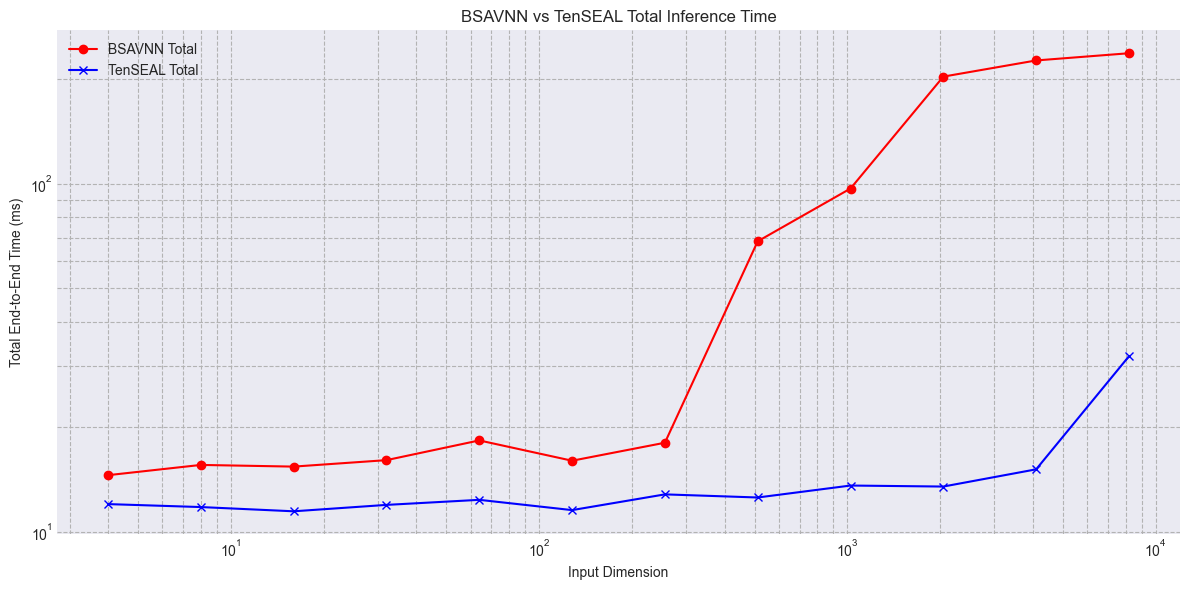

In [22]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(combined_df['input_dim'], combined_df['bsavnn_total_time_ms'], marker='o', label='BSAVNN Total', color='red')
plt.plot(combined_df['input_dim'], combined_df['tenseal_total_time_ms'], marker='x', label='TenSEAL Total', color='blue')
plt.xlabel('Input Dimension')
plt.ylabel('Total End-to-End Time (ms)')
plt.title('BSAVNN vs TenSEAL Total Inference Time')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', c='0.7')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
fig_width, fig_height = 12, 6

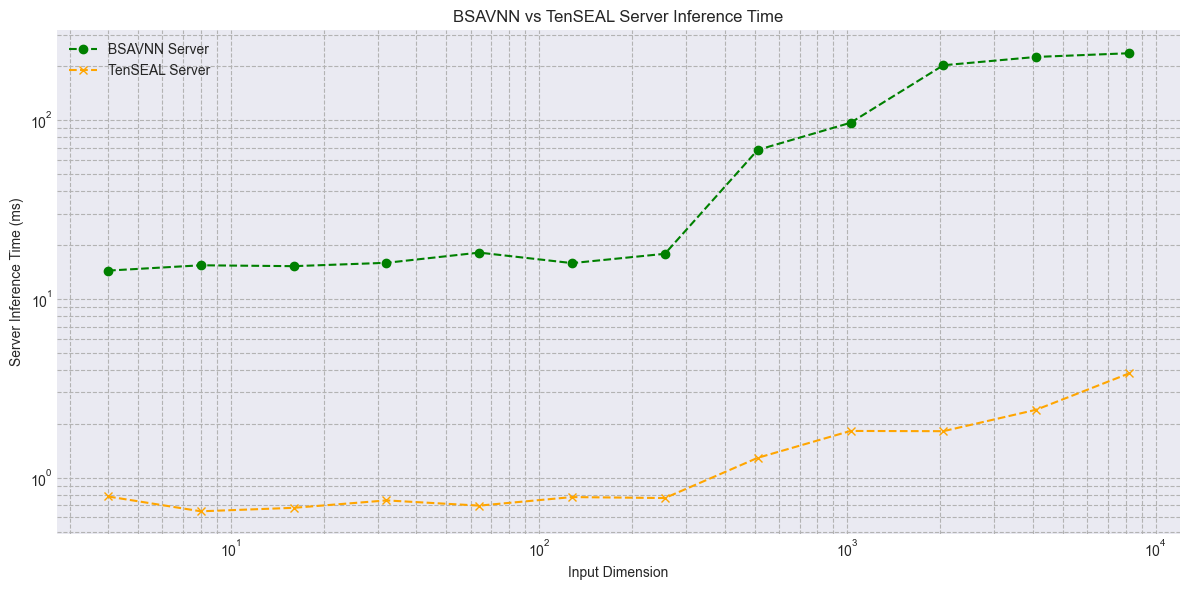

In [21]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(combined_df['input_dim'], combined_df['bsavnn_server_time_ms'], marker='o', linestyle='--', label='BSAVNN Server', color='green')
plt.plot(combined_df['input_dim'], combined_df['tenseal_server_time_ms'], marker='x', linestyle='--', label='TenSEAL Server', color='orange')
plt.xlabel('Input Dimension')
plt.ylabel('Server Inference Time (ms)')
plt.title('BSAVNN vs TenSEAL Server Inference Time')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', c='0.7')
plt.legend()
plt.tight_layout()
plt.show()

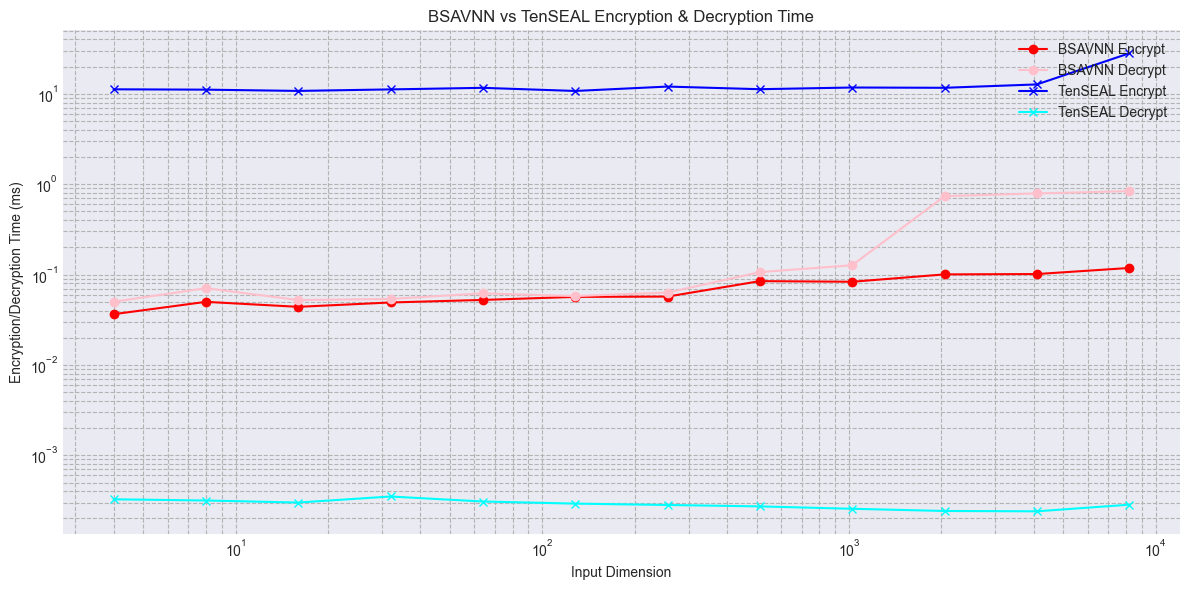

In [23]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(combined_df['input_dim'], combined_df['bsavnn_encrypt_time_ms'], marker='o', label='BSAVNN Encrypt', color='red')
plt.plot(combined_df['input_dim'], combined_df['bsavnn_decrypt_time_ms'], marker='o', label='BSAVNN Decrypt', color='pink')
plt.plot(combined_df['input_dim'], combined_df['tenseal_encrypt_time_ms'], marker='x', label='TenSEAL Encrypt', color='blue')
plt.plot(combined_df['input_dim'], combined_df['tenseal_decrypt_time_ms'], marker='x', label='TenSEAL Decrypt', color='cyan')
plt.xlabel('Input Dimension')
plt.ylabel('Encryption/Decryption Time (ms)')
plt.title('BSAVNN vs TenSEAL Encryption & Decryption Time')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', c='0.7')
plt.legend()
plt.tight_layout()
plt.show()

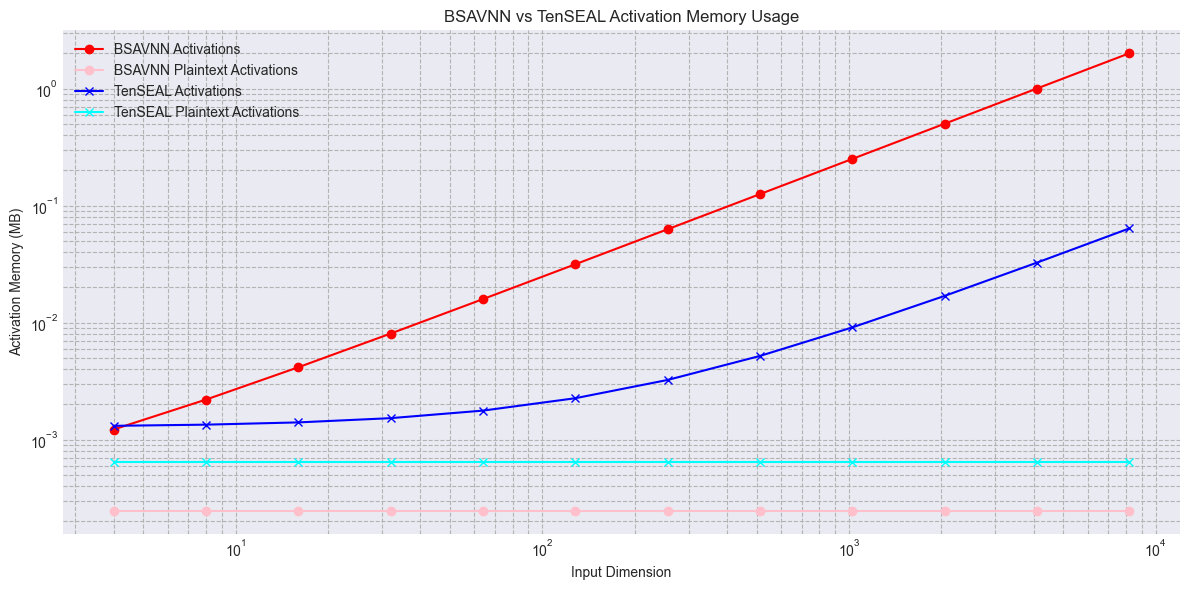

In [24]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(combined_df['input_dim'], combined_df['bsavnn_activation_mem_mb'], marker='o', label='BSAVNN Activations', color='red')
plt.plot(combined_df['input_dim'], combined_df['bsavnn_plaintext_mem_mb'], marker='o', label='BSAVNN Plaintext Activations', color='pink')
plt.plot(combined_df['input_dim'], combined_df['tenseal_activation_mem_mb'], marker='x', label='TenSEAL Activations', color='blue')
plt.plot(combined_df['input_dim'], combined_df['tenseal_plaintext_mem_mb'], marker='x', label='TenSEAL Plaintext Activations', color='cyan')
plt.xlabel('Input Dimension')
plt.ylabel('Activation Memory (MB)')
plt.title('BSAVNN vs TenSEAL Activation Memory Usage')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', c='0.7')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# --- Fix and create comparison DataFrame ---
comparison_df = pd.DataFrame({
    'input_dim': bsavnn_results_df['input_dim'],
    'bsavnn_total_time_ms': bsavnn_results_df['bsavnn_total_inference_time_ms'] if 'bsavnn_total_inference_time_ms' in bsavnn_results_df else bsavnn_results_df['bsavnn_total_time_ms'],
    'tenseal_total_time_ms': results_df['total_time_ms'],
    'bsavnn_server_time_ms': bsavnn_results_df['bsavnn_server_inference_time_ms'],
    'tenseal_server_time_ms': results_df['server_inference_time_ms'],
    'bsavnn_activation_mem_mb': bsavnn_results_df['bsavnn_activation_mem_mb'],
    'tenseal_activation_mem_mb': results_df['tenseal_activation_mem_mb'],
})

# Calculate relative overheads if not already in data
comparison_df['bsavnn_overhead_pct'] = ((comparison_df['bsavnn_total_time_ms'] - comparison_df['bsavnn_server_time_ms']) / comparison_df['bsavnn_server_time_ms']) * 100
comparison_df['tenseal_overhead_pct'] = ((comparison_df['tenseal_total_time_ms'] - comparison_df['tenseal_server_time_ms']) / comparison_df['tenseal_server_time_ms']) * 100

# Display the fixed comparison table
display(comparison_df[['input_dim', 
                       'bsavnn_total_time_ms', 'tenseal_total_time_ms', 
                       'bsavnn_activation_mem_mb', 'tenseal_activation_mem_mb',
                       'bsavnn_overhead_pct', 'tenseal_overhead_pct']])


,input_dim,bsavnn_total_time_ms,tenseal_total_time_ms,bsavnn_activation_mem_mb,tenseal_activation_mem_mb,bsavnn_overhead_pct,tenseal_overhead_pct
0,4,14.549440,12.016752,0.001221,0.001312,0.983625,1429.346990
1,8,15.569818,11.783900,0.002197,0.001343,0.918571,1714.918165
2,16,15.397834,11.457906,0.004150,0.001404,0.928926,1587.412995
3,32,16.070472,11.953736,0.008057,0.001526,0.889699,1500.378013
4,64,18.308570,12.360364,0.015869,0.001770,0.780091,1669.284707
5,128,16.008592,11.548510,0.031494,0.002258,0.893169,1380.809840
6,256,18.030942,12.814654,0.062744,0.003235,0.792198,1563.959751
7,512,68.308006,12.553408,0.125244,0.005188,0.207900,871.093851
8,1024,96.837984,13.585668,0.250244,0.009094,0.146560,643.440037
9,2048,202.958870,13.495220,0.500244,0.016907,0.069875,640.788203
